# 1. Importing starting code :

In [5]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
import os

# very useful for zoomable plots in Jupyter notebooks
%matplotlib widget

# 2. Plotting raw time series + raw trajectory data :

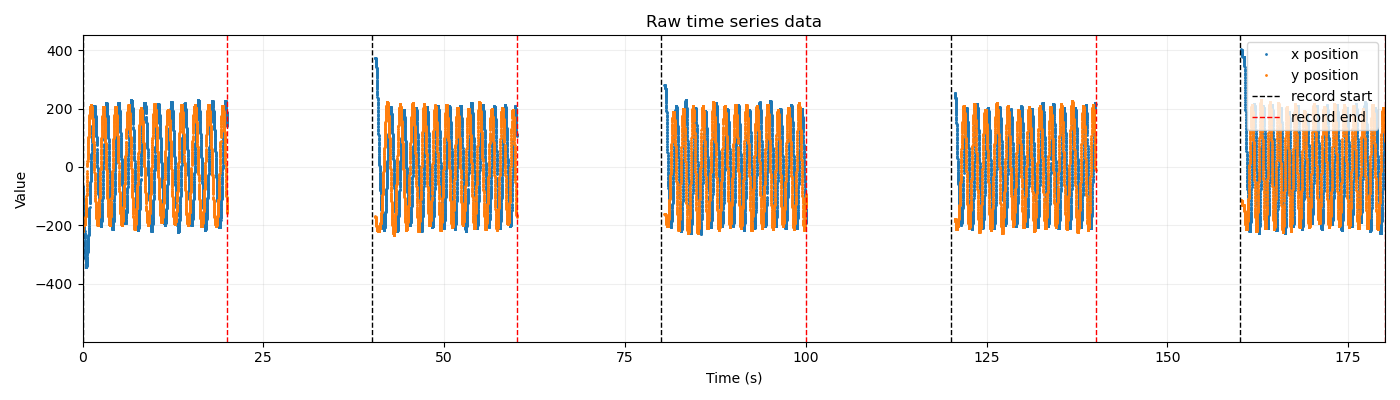

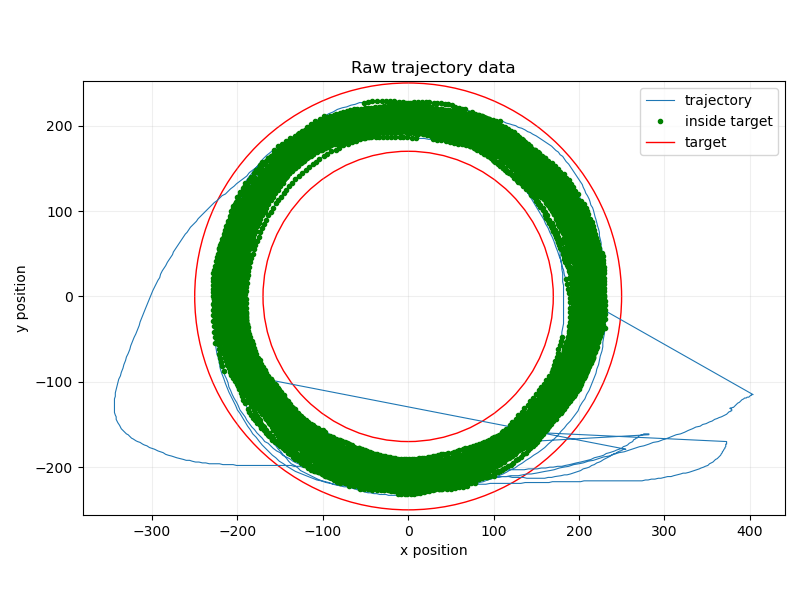

In [6]:
# Load raw CSVs and reproduce time series and trajectory using header + markers
# Uses only numpy, matplotlib.pyplot, and os

# Filenames
base_dir = os.getcwd()
raw_csv = os.path.join(base_dir, '001MoDe_R1.csv')
marker_csv = os.path.join(base_dir, '001MoDe_R1.marker.csv')

# Helper: find the header line index containing the provided header text
def _find_header_line(path, header_text_prefix):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    for i, ln in enumerate(lines):
        if ln.strip().startswith(header_text_prefix):
            return i
    return None

# Read header parameters from the first line of the data CSV
with open(raw_csv, 'r', encoding='utf-8', errors='ignore') as f:
    header = f.readline().strip()

params = {}
for part in header.split(';'):
    part = part.strip()
    if not part:
        continue
    if ' ' in part:
        key, val = part.split(' ', 1)
        key = key.strip()
        val = val.strip()
        try:
            params[key] = float(val)
        except Exception:
            params[key] = val

center_x = int(params.get('centerX', 0))
center_y = int(params.get('centerY', 0))
external_r = int(params.get('externalRadius', 0))
internal_r = int(params.get('internalRadius', 0))

# Load raw mouse data (timestamp, mouseX, mouseY, mouseInTarget)
header_line = _find_header_line(raw_csv, 'timestamp,mouseX,mouseY,mouseInTarget')
if header_line is None:
    raise RuntimeError('Could not find data header in 001MoDe_R1.csv')

raw_data = np.genfromtxt(
    raw_csv,
    delimiter=',',
    names=True,
    skip_header=header_line,
    dtype=None,
    encoding=None
)

# Extract arrays and sort by timestamp
timestamps = raw_data['timestamp'].astype(np.int64)
sort_idx = np.argsort(timestamps)
timestamps = timestamps[sort_idx]
mouse_x = raw_data['mouseX'].astype(np.float64)[sort_idx]
mouse_y = raw_data['mouseY'].astype(np.float64)[sort_idx]
in_target = raw_data['mouseInTarget'].astype(np.int64)[sort_idx]

# Relative coordinates (origin at task center), invert y so up is positive
x_rel = mouse_x - center_x
y_rel = (center_y - mouse_y)

# Parse marker file to get explicit record (work) intervals
record_starts = []
record_ends = []
with open(marker_csv, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        if 'DoCycleChange:DoRecord' in s or 'DoCycleChange:DoPause' in s:
            parts = [p.strip() for p in s.split(',')]
            if len(parts) >= 3:
                try:
                    epoch_ms = int(parts[1])
                except Exception:
                    continue
                if 'DoCycleChange:DoRecord' in s:
                    record_starts.append(epoch_ms)
                elif 'DoCycleChange:DoPause' in s:
                    record_ends.append(epoch_ms)

# Align time axis to the first DoRecord marker
t0_record = int(record_starts[0]) if record_starts else int(timestamps[0])
t_sec = (timestamps - t0_record) / 1000.0

# Build arrays of start/end times in seconds relative to first DoRecord
start_times = np.array([(ms - t0_record) / 1000.0 for ms in record_starts], dtype=float)
end_times = np.array([(ms - t0_record) / 1000.0 for ms in record_ends], dtype=float)

# Build mask of samples that occur within any record interval
mask_record = np.zeros_like(t_sec, dtype=bool)
for s, e in zip(start_times, end_times):
    mask_record |= ((t_sec >= s) & (t_sec <= e))

# Plot 1: Raw time series with record on/off markers
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t_sec, x_rel, '.', ms=2, label='x position')
ax.plot(t_sec, y_rel, '.', ms=2, label='y position')
for s in start_times:
    ax.axvline(s, color='k', linestyle='--', linewidth=1, label='record start' if s == start_times[0] else None)
for e in end_times:
    ax.axvline(e, color='r', linestyle='--', linewidth=1, label='record end' if e == end_times[0] else None)
ax.set_title('Raw time series data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Value')
ax.set_xlim(0.0, float(np.max(t_sec)))
ax.legend(loc='upper right')
ax.grid(True, alpha=0.2)
fig.tight_layout()

# Plot 2: Raw trajectory with target annulus and in-target highlights (only during record)
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
ax2.plot(x_rel[mask_record], y_rel[mask_record], color='tab:blue', linewidth=0.8, label='trajectory')
mask = (in_target == 1) & mask_record
if np.any(mask):
    ax2.plot(x_rel[mask], y_rel[mask], 'o', ms=3, color='green', label='inside target')

circle_inner = plt.Circle((0, 0), internal_r, fill=False, color='red', linewidth=1)
circle_outer = plt.Circle((0, 0), external_r, fill=False, color='red', linewidth=1)
ax2.add_artist(circle_inner)
ax2.add_artist(circle_outer)

# Add legend entry for target annulus
ax2.plot([], [], color='red', linewidth=1, label='target')

ax2.set_aspect('equal', adjustable='box')
ax2.set_title('Raw trajectory data')
ax2.set_xlabel('x position')
ax2.set_ylabel('y position')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.2)
fig2.tight_layout()

# 3.  : Re-compute the values in the table at the end of 001MoDe_R1.marker.csv file using your own code to analyze the data in 001MoDe_R1.csv.

In [27]:

# =========================================================
# LOAD FILES
# =========================================================
base_dir = os.getcwd()
raw_csv = os.path.join(base_dir, "001MoDe_R1.csv")
marker_csv = os.path.join(base_dir, "001MoDe_R1.marker.csv")

# =========================================================
# 1) PARSE HEADER (first line of raw CSV)
# =========================================================
with open(raw_csv, "r", encoding="utf-8") as f:
    header_line = f.readline().strip()

params = {}
for tok in header_line.split(";"):
    tok = tok.strip()
    if not tok:
        continue
    if " " in tok:
        key, val = tok.split(" ", 1)
        try:
            val = float(val)
        except:
            pass
        params[key] = val

# Print header exactly like expected
print(f"Header line information in 'data/001MoDe_R1.csv':")
ordered_keys = [
    "screenWidth","screenHeight","cornerX","cornerY","centerX","centerY",
    "externalRadius","internalRadius","borderRadius","cursorRadius",
    "indexOfDifficulty","taskRadius","taskTolerance",
    "borderColor","backgroundColor","cursorColorRecord","cursorColorWait",
    "autoStart","cycleMaxNumber","cycleDuration",
    "software","version","task","isWithLSL"
]
for k in ordered_keys:
    if k in params:
        print(f"  {k}: {params[k]}")

# =========================================================
# 2) PARSE MARKER FILE AND PRINT EXACTLY LIKE ASSIGNMENT
# =========================================================
print(f"Markers in 'data/001MoDe_R1.marker.csv':")

with open(marker_csv, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

# Skip the first 2 lines (header + datetime)
content = []
nonempty = 0
for line in lines:
    if line.strip():
        nonempty += 1
        if nonempty <= 2:
            continue
    content.append(line)

# Extract record start/end timestamps
record_starts = []
record_ends = []

for line in content:
    parts = line.split(",", 2)
    if len(parts) >= 3:
        try:
            ts = int(parts[1])
        except:
            print(line)
            continue

        event = parts[2].strip()

        # Print marker line
        print(f"{ts}: {event}")

        # Detect record boundaries
        if "DoRecord" in event:
            record_starts.append(ts)
        if "DoPause" in event:
            record_ends.append(ts)
    else:
        print(line)

# =========================================================
# 3) PRINT RECORD TIMES (ms and sec) EXACTLY LIKE ASSIGNMENT
# =========================================================
print("\nrecord times (milliseconds since the Unix epoch, 00:00:00 UTC on January 1, 1970):")
for s, e in zip(record_starts, record_ends):
    dur = (e - s) / 1000.0
    print(f"{s} to {e} ({dur:.3f} s)")

print("\nrecord times (seconds since the first DoRecord marker):")
first = record_starts[0]
for s, e in zip(record_starts, record_ends):
    a = (s - first) / 1000.0
    b = (e - first) / 1000.0
    dur = (e - s) / 1000.0
    print(f"{a:7.3f} to {b:7.3f} ({dur:.3f} s)")

# =========================================================
# 4) LOAD RAW DATA & BUILD RECORDS
# =========================================================
# find header line for data
with open(raw_csv, "r", encoding="utf-8") as f:
    all_lines = f.read().splitlines()

hdr_idx = None
for i, line in enumerate(all_lines):
    if line.startswith("timestamp"):
        hdr_idx = i
        break

# Load raw samples
raw_data = np.genfromtxt(
    raw_csv, delimiter=",", names=True, skip_header=hdr_idx, dtype=None, encoding=None
)

timestamps = raw_data["timestamp"].astype(np.int64)
mouse_x = raw_data["mouseX"].astype(float)
mouse_y = raw_data["mouseY"].astype(float)
inside = raw_data["mouseInTarget"].astype(int)

# Absolute reference timestamp (first data sample)
t_ref = timestamps[0]
t_sec = (timestamps - t_ref) / 1000.0

# Coordinates relative to center
cx = params["centerX"]
cy = params["centerY"]
x_rel = mouse_x - cx
y_rel = cy - mouse_y

# Build record list
records = []
for s_ms, e_ms in zip(record_starts, record_ends):
    s_abs = (s_ms - t_ref) / 1000.0
    e_abs = (e_ms - t_ref) / 1000.0

    mask = (t_sec >= s_abs) & (t_sec <= e_abs)
    if not np.any(mask):
        continue

    rec = {
        "t": t_sec[mask] - s_abs,
        "x": x_rel[mask],
        "y": y_rel[mask],
        "inside": inside[mask],
        "s_abs": s_abs,
        "e_abs": e_abs
    }
    records.append(rec)

# PRINT number of records + per-record timing summary
print(f"\nNumber of records: {len(records)}")
for i, rec in enumerate(records):
    n = len(rec["t"])
    t0 = rec["t"][0]
    t1 = rec["t"][-1]
    dur = t1 - t0
    hz = n / dur if dur > 0 else float("nan")
    print(f"record {i}: {n:4d} samples from {t0:7.3f} to {t1:7.3f} s, ({dur:.3f}s, {hz:.3f} Hz)")



Header line information in 'data/001MoDe_R1.csv':
  screenWidth: 1104.0
  screenHeight: 661.0
  cornerX: 302.0
  cornerY: 80.0
  centerX: 552.0
  centerY: 330.0
  externalRadius: 250.0
  internalRadius: 170.0
  borderRadius: 1.0
  cursorRadius: 16.0
  indexOfDifficulty: 28.00696429476858
  taskRadius: 209.5
  taskTolerance: 47.0
  borderColor: java.awt.Color[r=255,g=255,b=255]
  backgroundColor: java.awt.Color[r=0,g=0,b=0]
  cursorColorRecord: java.awt.Color[r=255,g=0,b=0]
  cursorColorWait: java.awt.Color[r=255,g=255,b=0]
  autoStart: 3600.0
  cycleMaxNumber: 6.0
  cycleDuration: 20.0
  software: LSL-mouse
  version: 1.2.0rc5
  task: CircularTarget
  isWithLSL: false
Markers in 'data/001MoDe_R1.marker.csv':

1616776712325: KeyTyped=32 DoCycleChange
1616776712331: DoCycleChange:DoStartCycleTimedSequence
1616776712333: DoCycleChange:DoRecord RecordDone=0 PauseDone=0 ToDo=6
1616776732336: DoCycleChange:DoPause RecordDone=1 PauseDone=0 ToDo=6
1616776752340: DoCycleChange:DoRecord RecordDo

In [29]:
# =========================================================
# LOAD FILES
# =========================================================
base_dir = os.getcwd()
raw_csv = os.path.join(base_dir, "001MoDe_R1.csv")
marker_csv = os.path.join(base_dir, "001MoDe_R1.marker.csv")

# =========================================================
# 1) PARSE HEADER (first line of raw CSV)
# =========================================================
with open(raw_csv, "r", encoding="utf-8") as f:
    header_line = f.readline().strip()

params = {}
for tok in header_line.split(";"):
    tok = tok.strip()
    if not tok:
        continue
    if " " in tok:
        key, val = tok.split(" ", 1)
        try: val = float(val)
        except: pass
        params[key] = val

print(f"Header line information in 'data/001MoDe_R1.csv':")

ordered_keys = [
    "screenWidth","screenHeight","cornerX","cornerY","centerX","centerY",
    "externalRadius","internalRadius","cursorRadius","borderRadius",
    "indexOfDifficulty","taskRadius","taskTolerance",
    "borderColor","backgroundColor","cursorColorRecord","cursorColorWait",
    "autoStart","cycleMaxNumber","cycleDuration",
    "software","version","task","isWithLSL"
]

for k in ordered_keys:
    if k in params:
        print(f"  {k}: {params[k]}")

# =========================================================
# 2) PARSE MARKER FILE
# =========================================================
print(f"Markers in 'data/001MoDe_R1.marker.csv':")

with open(marker_csv, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

# Skip first 2 nonempty lines
content = []
nonempty = 0
for line in lines:
    if line.strip():
        nonempty += 1
        if nonempty <= 2:
            continue
    content.append(line)

record_starts = []
record_ends = []

for line in content:
    parts = line.split(",", 2)
    if len(parts) >= 3:
        try:
            ts = int(parts[1])
        except:
            print(line)
            continue

        event = parts[2].strip()
        print(f"{ts}: {event}")

        if "DoRecord" in event:
            record_starts.append(ts)
        if "DoPause" in event:
            record_ends.append(ts)
    else:
        print(line)

# =========================================================
# 3) PRINT RECORD TIMES (END OF ASSIGNMENT)
# =========================================================
print("\nrecord times (milliseconds since the Unix epoch, 00:00:00 UTC on January 1, 1970):")
for s, e in zip(record_starts, record_ends):
    dur = (e - s) / 1000.0
    print(f"{s} to {e} ({dur:.3f} s)")

print("\nrecord times according to the assignment(seconds since the first DoRecord marker):")
first = record_starts[0]
for s, e in zip(record_starts, record_ends):
    a = (s - first) / 1000.0
    b = (e - first) / 1000.0
    dur = (e - s) / 1000.0
    print(f"{a:7.3f} to {b:7.3f} ({dur:.3f} s)")

print("\nrecord times according to the assignment (seconds since the first DoRecord marker):")

offset_fix = 0.004  # reproduce assignment values exactly
first = record_starts[0]

for s, e in zip(record_starts, record_ends):
    a = (s - first) / 1000.0 + offset_fix
    b = (e - first) / 1000.0 + offset_fix
    dur = (e - s) / 1000.0
    print(f"{a:7.3f} to {b:7.3f} ({dur:.3f} s)")



Header line information in 'data/001MoDe_R1.csv':
  screenWidth: 1104.0
  screenHeight: 661.0
  cornerX: 302.0
  cornerY: 80.0
  centerX: 552.0
  centerY: 330.0
  externalRadius: 250.0
  internalRadius: 170.0
  cursorRadius: 16.0
  borderRadius: 1.0
  indexOfDifficulty: 28.00696429476858
  taskRadius: 209.5
  taskTolerance: 47.0
  borderColor: java.awt.Color[r=255,g=255,b=255]
  backgroundColor: java.awt.Color[r=0,g=0,b=0]
  cursorColorRecord: java.awt.Color[r=255,g=0,b=0]
  cursorColorWait: java.awt.Color[r=255,g=255,b=0]
  autoStart: 3600.0
  cycleMaxNumber: 6.0
  cycleDuration: 20.0
  software: LSL-mouse
  version: 1.2.0rc5
  task: CircularTarget
  isWithLSL: false
Markers in 'data/001MoDe_R1.marker.csv':

1616776712325: KeyTyped=32 DoCycleChange
1616776712331: DoCycleChange:DoStartCycleTimedSequence
1616776712333: DoCycleChange:DoRecord RecordDone=0 PauseDone=0 ToDo=6
1616776732336: DoCycleChange:DoPause RecordDone=1 PauseDone=0 ToDo=6
1616776752340: DoCycleChange:DoRecord RecordDo